# This project uses Python and Spark to predict the sentiment of Amazon Alexa reviews.

In [44]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [45]:
#Loading the dataset
data = pd.read_csv(r'https://raw.githubusercontent.com/nsrozak/Python_AlexaSentimentAnalysis/master/amazon_alexa.tsv',sep='\t')
data.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [46]:
# Creating a new column sentiment based on overall ratings
def sentiments(df):
    if df['rating'] > 3.0:
        return 'Positive'
    elif df['rating'] <= 3.0:
        return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [47]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [48]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    1
sentiment           0
dtype: int64

In [49]:
data_v1.dropna(subset=['verified_reviews'],inplace=True) #Dropping the row which has null value

In [50]:
data_v1.isnull().sum() #Again Checking Null Values

verified_reviews    0
sentiment           0
dtype: int64

In [51]:
def cleaning(df, stop_words):
    
    #converting to lowercase
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join(x.lower() for x in x.split()))


    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace('d', ''

            )

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)

In [52]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


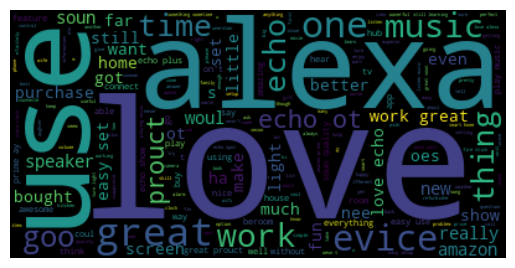

In [53]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')  #Displaying most common words
plt.axis("off")
plt.show()

In [54]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

In [55]:
data_v1.head(10)

,verified_reviews,sentiment
0,love echo!,1
1,love it!,1
2,"sometimes playing game, answer question correc...",1
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",1
4,music,1
5,receive echo gift. neee another bluetooth some...,1
6,"without cellphone, cannot use many features. i...",0
7,think 5th one i've purchase. i'm working getti...,1
8,look great,1
9,love it! i’ve listene song haven’t hear since ...,1


In [68]:
tokenizer = Tokenizer(num_words=500, split=' ') #Tokenizing with 500 frequent words
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data_v1['verified_reviews'].values) #converting text into sequence of words
X = pad_sequences(X)  # pads the sequences to ensure they have the same length.
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   1,   5],
       [  0,   0,   0, ...,  43, 276,  24],
       ...,
       [  0,   0,   0, ...,  89,  50,  32],
       [  0,   0,   0, ...,   2,  65, 124],
       [  0,   0,   0, ...,   0,   0,  16]])

In [69]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [70]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [71]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [72]:
batch_size=32
model.fit(X_train, y_train, epochs = 3, batch_size=batch_size, verbose = 1)

Epoch 1/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.8533 - loss: 0.4420
Epoch 2/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.8730 - loss: 0.3300
Epoch 3/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.9133 - loss: 0.2264


In [73]:
model.evaluate(X_test,y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8651 - loss: 0.3192


[0.2904292047023773, 0.879365086555481]